# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
    """
Steering angle prediction model
"""

#importing some useful packages

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
from PIL import Image
import keras
import math
import random
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, Adam, RMSprop
from scipy.misc.pilutil import imresize
from sklearn.utils import shuffle

import os
import argparse
import json
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, MaxPooling2D
from keras.layers.convolutional import Convolution2D
from keras.callbacks import ModelCheckpoint

import cv2
import numpy as np
import sklearn
from keras.layers import Cropping2D, Input, Dense
from keras.models import Model

import csv
import cv2
import numpy as np

Using TensorFlow backend.


In [14]:
#
# Read all the images into arrays and the steering angles.
#
dir = 'mydata'
lines = []
with open(dir + '/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)
    for line in reader:
        lines.append(line)

imagesC = []
imagesL = []
imagesR = []
measurements = []

i = 0;
for line in lines:
    source_path = line[0]
    filenameC = source_path.split('/')[-1]
    current_path = dir + '/IMG/' + filenameC
    img = Image.open(current_path)
    imageC = cv2.imread(current_path)
    imagesC.append(imageC)
    source_pathL = line[1]
    filenameL = source_pathL.split('/')[-1]
    current_path = dir + '/IMG/' + filenameL
    imageL = cv2.imread(current_path)
    imagesL.append(imageL)
    source_pathR = line[2]
    filenameR = source_pathR.split('/')[-1]
    current_path = dir + '/IMG/' + filenameR
    imageR = cv2.imread(current_path)
    imagesR.append(imageR)
    measurement = float(line[3])
    measurements.append(measurement)


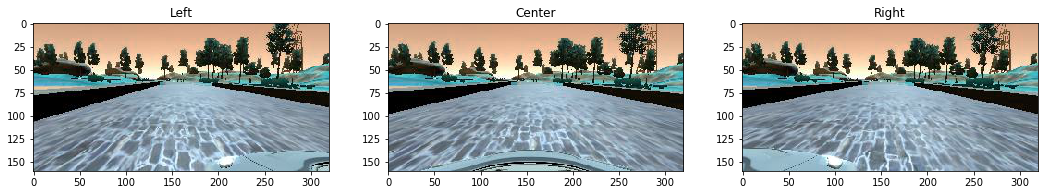

In [16]:
import matplotlib.pyplot as plt

imageC0 = imagesC[0]
imageL0 = imagesL[0]
imageR0 = imagesR[0]

plt.figure(figsize=(18,6))
plt.subplot(131)
plt.title('Left')
plt.imshow(imageL0)
plt.subplot(132)
plt.title('Center')
plt.imshow(imageC0)
plt.subplot(133)
plt.title('Right')
plt.imshow(imageR0)

(80, 320, 3)

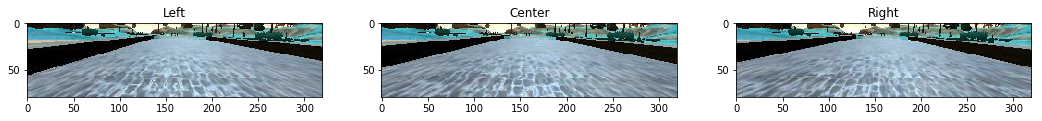

In [4]:
crop_start = 50
crop_end = 130
crop_imageL0 = imageL0[crop_start:crop_end, :]
crop_imageC0 = imageC0[crop_start:crop_end, :]
crop_imageR0 = imageR0[crop_start:crop_end, :]
#crop_imageR0 = cv2.resize(crop_imageR0, (320, 160), interpolation = cv2.INTER_LINEAR)
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.title('Left')
plt.imshow(crop_imageL0)
plt.subplot(132)
plt.title('Center')
plt.imshow(crop_imageC0)
plt.subplot(133)
plt.title('Right')
plt.imshow(crop_imageR0)
crop_imageL0.shape

In [5]:
# Check to see if the steering angle is above threshold for 50% of the samples.
def check_good_steering_angle(yi): 
    probability = random.random()
    if (probability > 0.5 or abs(yi) > 0.01):
       return True
    else:
        return False

trans_range = 100
def trans_image(image, steer):
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer - tr_x/trans_range* 2.0 * 0.2
    tr_y = 0
    rows, cols, ch = image.shape
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    return image_tr,steer_ang

def flip_image(image):
    flipimage = np.fliplr(image)
    return flipimage


In [6]:
# Fill the samples array. Skip the first line.
samples = []
linec = 0
with open(dir + '/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if(linec > 0):
            samples.append(line)
        linec = linec + 1

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print('Train size ', len(train_samples))
print('Valid size ', len(validation_samples))

# Reduce the pictures with low steering angles.
good_train_samples = []
 
for tsam in train_samples:
    name = dir + '/IMG/' + tsam[0].split('/')[-1]
    center_angle = float(tsam[3])
    if(check_good_steering_angle(center_angle)):
#        print('Steering ', center_angle, tsam[0])
        good_train_samples.append(tsam)

print('Good train size ', len(good_train_samples))
train_samples = good_train_samples



Train size  6428
Valid size  1608
Good train size  4660


Shape  (80, 320, 3)  Steer  0.19018085446114893


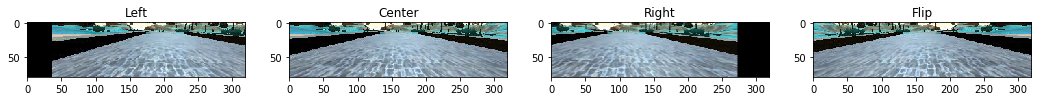

In [7]:

sangle = measurements[0]
plt.figure(figsize=(18,6))
plt.subplot(141)
plt.title('Left')
lcimage, steer = trans_image(crop_imageL0, sangle)
plt.imshow(lcimage)
plt.subplot(142)
plt.title('Center')
plt.imshow(crop_imageC0)
plt.subplot(143)
plt.title('Right')
rcimage, steer = trans_image(crop_imageR0, sangle)
plt.imshow(rcimage)
print('Shape ', rcimage.shape, ' Steer ', steer)
plt.subplot(144)
plt.title('Flip')
plt.imshow(flip_image(crop_imageC0))

In [8]:

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                cname = dir + '/IMG/'+batch_sample[0].split('/')[-1]
                lname = dir + '/IMG/'+batch_sample[1].split('/')[-1]
                rname = dir + '/IMG/'+batch_sample[2].split('/')[-1]
                sangle = float(batch_sample[3])
                use_angle = sangle
                sub_angle = use_angle - 0.25
                add_angle = use_angle + 0.25
                if(sangle < 0.01):
                    chance = random.random()
                    if(chance > 0.75):
                        rimage = cv2.imread(rname)
                        use_image, use_angle = trans_image(rimage, sangle)
                        use_angle = use_angle - 0.25
                    else:
                        if(chance > 0.49):
                            rimage = cv2.imread(rname)
                            use_image, use_angle = trans_image(rimage, sangle)
                            use_angle = use_angle - 0.25
                        else:
                            cimage = cv2.imread(cname)
                            use_image = cimage
                elif(sangle > 0.01):
                    chance = random.random()
                    if(chance > 1.0):
                        limage = cv2.imread(lname)
                        use_image, use_angle = trans_image(limage, sangle)
                        use_angle = use_angle + 0.25
                    else:
                        if(chance > 0.49):
                            limage = cv2.imread(lname)
                            use_image, use_angle = trans_image(limage, sangle)
                            use_angle = use_angle + 0.25
                        else:
                            cimage = cv2.imread(cname)
                            use_image = cimage
               
                if np.random.choice([True, False]):
                    use_image = flip_image(use_image)
                    use_angle = -use_angle
            
                images.append(use_image)
                angles.append(use_angle)
 
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)


Train on 11500 samples, validate on 2875 samples
Epoch 1/5
11500/11500 [==============================] - 64s - loss: 0.1297 - val_loss: 0.0298
Epoch 2/5
11500/11500 [==============================] - 62s - loss: 0.0199 - val_loss: 0.0241
Epoch 3/5
11500/11500 [==============================] - 62s - loss: 0.0127 - val_loss: 0.0237
Epoch 4/5
11500/11500 [==============================] - 62s - loss: 0.0090 - val_loss: 0.0251
Epoch 5/5
11500/11500 [==============================] - 62s - loss: 0.0067 - val_loss: 0.0220
dict_keys(['val_loss', 'loss'])


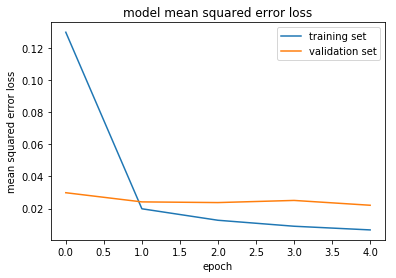

In [9]:
X_t = []
m_t = []
X_train = []
correction = 0.25

dsize = len(imagesC)
for i in range(0, dsize):
    sa = measurements[i]
    if (sa < -0.1 and sa > float('-inf') ) or (sa > 0.1 and sa < float('inf')):
        X_t.append(imagesC[i])
        m_t.append(sa)
        X_t.append(flip_image(imagesC[i]))
        m_t.append(-sa)
        X_t.append(imagesL[i])
        m_t.append(sa+correction)
        X_t.append(imagesR[i])
        m_t.append(sa-correction)
    else:
        use_image, use_angle = trans_image(imagesC[i], sa)
        X_t.append(use_image)
        m_t.append(use_angle)


X_train = np.array(X_t)
y_train = np.array(m_t)
    
    
chs, rows, cols = 3, 80, 320  # Trimmed image format


#Make the model
model = Sequential()
model.add(Cropping2D(cropping=((50,30), (0,0)), input_shape=(160,320,3)))

model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(rows, cols, chs), output_shape=(rows, cols, chs)))

#CA24_5_2_VALID
model.add(Convolution2D(24, 5, 5, subsample=(2,2), border_mode='same'))
model.add(ELU())

    
#CA36_5_2_VALID
model.add(Convolution2D(36, 5, 5, subsample=(2,2), border_mode='same'))
model.add(ELU())

    
#CA48_5_2_VALID
model.add(Convolution2D(48, 5, 5, subsample=(2,2), border_mode='same'))
model.add(ELU())

    
#CA64_3_1_VALID
model.add(Convolution2D(64, 3, 3, subsample=(1,1), border_mode='same'))
model.add(ELU())

    
#CA64_3_1_VALID
model.add(Convolution2D(64, 3, 3, subsample=(1,1), border_mode='same'))
model.add(ELU())

    
#FL
model.add(Flatten())
    
#FCA1164
model.add(Dense(1164))
model.add(ELU())

    
#FCA100
model.add(Dense(100))
model.add(ELU())

    
#FCA50
model.add(Dense(50))
model.add(ELU())
    
#FC1
model.add(Dense(1))
    
model.compile(loss='mse', optimizer='adam')
history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=5)

#model.fit_generator(train_generator, samples_per_epoch=len(train_samples), 
#            validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=3)


### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()


model.save('model.h5')

#Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas